In [2]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import execute, BasicAer, Aer, transpile
from random import randrange
import numpy as np
from project.unified_noise_model.Unified_Noise_Model import Unified_Noise_Model

from qiskit.circuit.library import XGate

from scipy.optimize import minimize

# 1.- Define one qubit circuit 

/home/onofre/anaconda3/envs/noise_native_gates/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


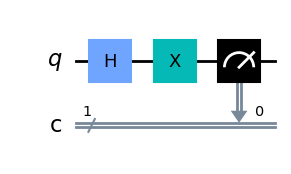

In [44]:
qc_test = QuantumCircuit(1,1)
qc_test.h(0)
qc_test.x(0)
qc_test.measure(0,0)
qc_test.draw('mpl')

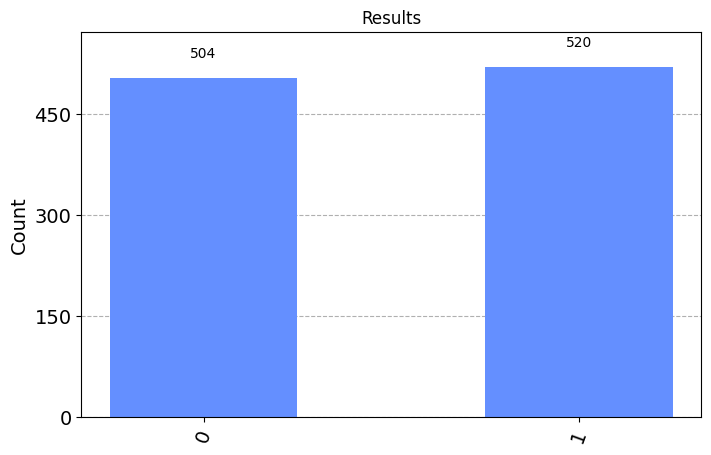

In [33]:
qc_transpile_test = transpile(qc_test, basis_gates=['ry', 'rx', 'rz'])
job = execute(qc_transpile_test ,Aer.get_backend('qasm_simulator'),shots=1024)
job_result = job.result()
counts = job_result.get_counts()
display(plot_histogram(counts,title='Results' ,figsize=[8,5]))

# 2.- Descomposition and inverse

/home/onofre/anaconda3/envs/noise_native_gates/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


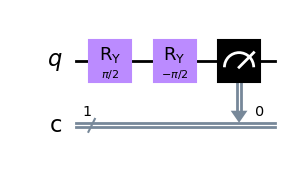

In [34]:
qc_test_2 = QuantumCircuit(1,1)
qc_test_2.h(0)
qc_test_2.x(0)
#qc_test.measure(0,0)
qc_test.draw('mpl')

# Descomposion into rotatations
qc_transpile = transpile(qc_test_2, basis_gates=['ry', 'rx', 'rz'])

qc_transpile.compose(qc_transpile.inverse(),[0],inplace=True)
qc_transpile.measure(0,0)

qc_transpile.draw('mpl')

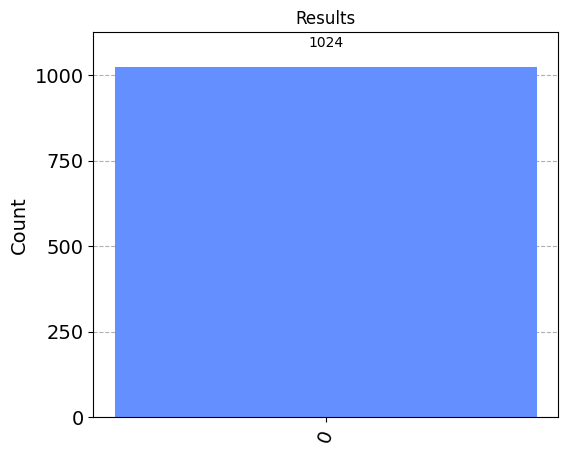

In [35]:
job_2 = execute(qc_transpile,Aer.get_backend('qasm_simulator'),shots=1024)
job_result_2 = job_2.result()
counts_2 = job_result_2.get_counts()
display(plot_histogram(counts_2,title='Results' ,figsize=[6,5]))

# 3.- Compute cost

In [36]:
def compute_cost(results_circuit, shots):
    #calculate the cost
    if results_circuit['0']>=0:
        cost = 1 - results_circuit['0']/shots
    else:
        cost =1
    
    return cost 

## Cost with descomposition and inverse 

In [37]:
job_2 = execute(qc_transpile,Aer.get_backend('qasm_simulator'),shots=1024)
job_result_2 = job_2.result()
counts_2 = job_result_2.get_counts()

print(compute_cost(counts_2, 1024))
#display(plot_histogram(counts,title='Results' ,figsize=[6,5]))

0.0


## Cost with no descomposition and inverse

In [38]:
job = execute(qc_transpile_test,Aer.get_backend('qasm_simulator'),shots=1024)
job_result = job.result()
counts = job_result.get_counts(qc_test)

print(compute_cost(counts, 1024))

#display(plot_histogram(counts,title='Results' ,figsize=[8,5]))

0.494140625


# 3.- Simulation with noise

In [45]:
#Noise model and other params
depol_noise_prob = 0.000323
stateprep_noise_prob = 0
measurement_error_prob = 0.049
num_qubits = 1
num_gates_to_optimize = 2

#global circuits to modify
qc = QuantumCircuit(1,1)
qc_reversed = QuantumCircuit(1,1)
qc_final = QuantumCircuit(1,1)
update_circuit = True

unm = Unified_Noise_Model()
x_StatePreparation = XGate(label='x_StatePreparation')

#Cause there is no state preparation, this part of SPAM channel will not affect
unm.add_all_noise_channels(
state_preparation_error_prob=stateprep_noise_prob,
measurement_error_prob=measurement_error_prob,
state_preparation_error_gate=x_StatePreparation,
depolarizing_prob=depol_noise_prob,
one_qubit_gates=['rx','ry', 'rz', 'h', 'x'],
one_qubit_gates_times=[[3.56E-6,3.56E-6,3.56E-6,3.56E-6,3.56E-6]],
two_qubits_gates=[],
two_qubits_gates_times=[],
qubits=range(num_qubits),
qubits_T1=[	0.0001,0.0001,0.0001,0.0001,0.0001],
qubits_T2=[0.0001,0.0001,0.0001,0.0001,0.0001]
)


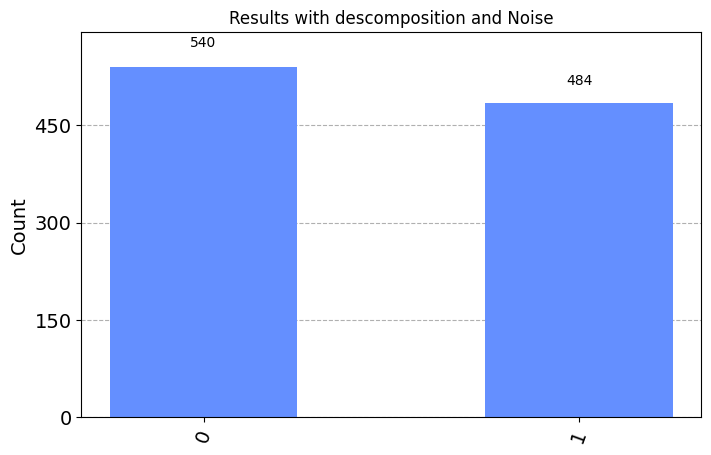

In [48]:
#calculate the fidelity
simulator_noise_inverse = AerSimulator(noise_model=unm.noise_model)
result_noise_inverse = simulator_noise_inverse.run(qc_transpile_test,shots=1024).result()
counts_noise_inverse =result_noise_inverse.get_counts()

display(plot_histogram(counts_noise_inverse ,title='Results with descomposition and Noise' ,figsize=[8,5]))

In [49]:
print(compute_cost(counts_noise_inverse, 1024))

0.47265625


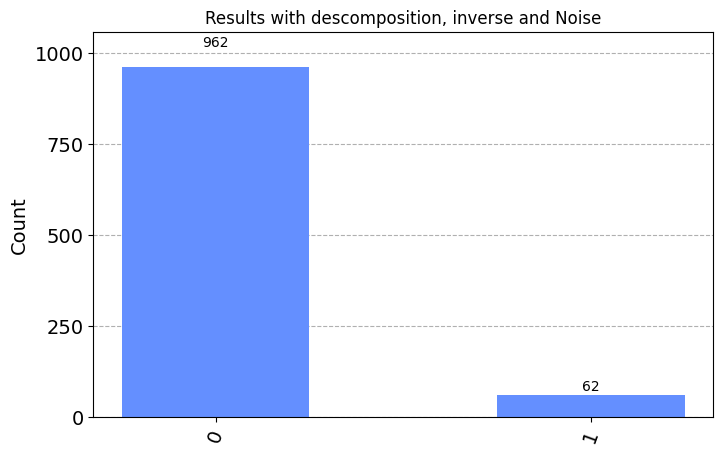

In [50]:
#calculate the fidelity
simulator_noise = AerSimulator(noise_model=unm.noise_model)
result_noise = simulator_noise.run(qc_transpile,shots=1024).result()
counts_noise = result_noise.get_counts()

display(plot_histogram(counts_noise,title='Results with descomposition, inverse and Noise' ,figsize=[8,5]))

In [51]:
print(compute_cost(counts_noise, 1024))

0.060546875


# 4.- Testing with random parameters

/home/onofre/anaconda3/envs/noise_native_gates/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


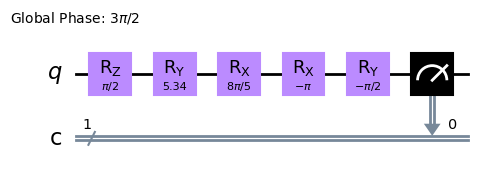

In [52]:
qc = QuantumCircuit(1,1)
qc_optimized = QuantumCircuit(1,1)
qc.h(0)
#qc.x(0)
#qc_test.measure(0,0)
qc.draw('mpl')

# Descomposion into rotatations
qc_transpile_2 = transpile(qc, basis_gates=['ry', 'rx', 'rz'])

qc_optimized.rz(randrange(0,21)/10*np.pi,0)
qc_optimized.ry(randrange(0,21)/10*np.pi,0)
qc_optimized.rx(randrange(0,21)/10*np.pi,0)

qc_optimized.compose(qc_transpile_2.inverse(),[0],inplace=True)
qc_optimized.measure(0,0)

qc_optimized.draw('mpl')

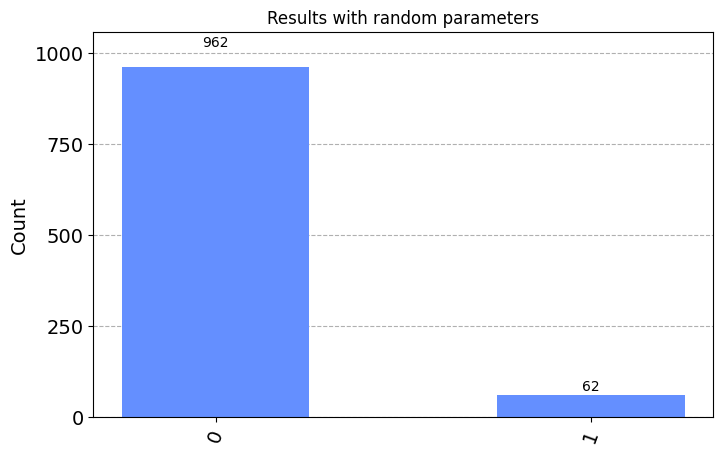

In [53]:
#calculate the fidelity
simulator_random_parameters = AerSimulator(noise_model=unm.noise_model)
result_noise_random_parameters = simulator_noise.run(qc_optimized,shots=1024).result()
counts_noise_random_parameters = result_noise.get_counts()

display(plot_histogram(counts_noise_random_parameters,title='Results with random parameters' ,figsize=[8,5]))

In [54]:
print(compute_cost(counts_noise_random_parameters , 1024))

0.060546875


# 5.- Optimization

In [55]:
def create_circuit(original_circ,
                   parameters):
    
    qc_optimized = QuantumCircuit(1,1)
    
    qc_trans = transpile(original_circ, basis_gates=['ry', 'rx', 'rz'])
    
    qc_optimized.rz(parameters[0]*np.pi,0)
    qc_optimized.ry(parameters[1]*np.pi,0)
    qc_optimized.rx(parameters[2]*np.pi,0)
    
    qc_optimized.compose(qc_trans.inverse(),[0],inplace=True)
    qc_optimized.measure(0,0)
    
    return qc_optimized
    
    

In [56]:
def cost_func(optimized_operation_params,
              *args):
    circuit, noise = args
    
    new_circuit = create_circuit(circuit,optimized_operation_params)
    
    simulator  = AerSimulator(noise_model=noise)
    result = simulator.run(new_circuit,shots=1024).result()
    counts = result.get_counts()
    cost = compute_cost(counts, 1024)
    
    return cost

/home/onofre/anaconda3/envs/noise_native_gates/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


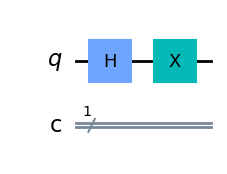

In [57]:
qc = QuantumCircuit(1,1)
qc.h(0)
qc.x(0)
#qc_test.measure(0,0)
qc.draw('mpl')

In [58]:
params = [np.random.uniform(0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1) ]
params

[0.4532956866467235, 0.5081300587413716, 0.2799692796094051]

In [59]:
params

[0.4532956866467235, 0.5081300587413716, 0.2799692796094051]

In [60]:
result=minimize(
    fun=cost_func,
    x0=params,
    args=(qc,unm.noise_model),
    method='COBYLA',
    tol=1e-5,
    options={"maxiter": 200})

In [61]:
result.x

array([0.19552331, 0.50684123, 1.27932608])

In [62]:
result.fun

0.0791015625

In [63]:
qc_testing = QuantumCircuit(1,1)

qc_testing.rz(result.x[0]*np.pi,0)
qc_testing.ry(result.x[1]*np.pi,0)
qc_testing.rx(result.x[2]*np.pi,0)

qc_testing.measure(0,0)

qc_testing.draw()

┌─────────────┐┌────────────┐┌────────────┐┌─┐
  q: ┤ Rz(0.61425) ├┤ Ry(1.5923) ├┤ Rx(4.0191) ├┤M├
     └─────────────┘└────────────┘└────────────┘└╥┘
c: 1/════════════════════════════════════════════╩═
                                                 0

In [66]:
simulator  = AerSimulator(noise_model=unm.noise_model)
result = simulator.run(qc_testing,shots=1024).result()
counts = result.get_counts()
cost = compute_cost(counts, 1024)
cost

0.4990234375

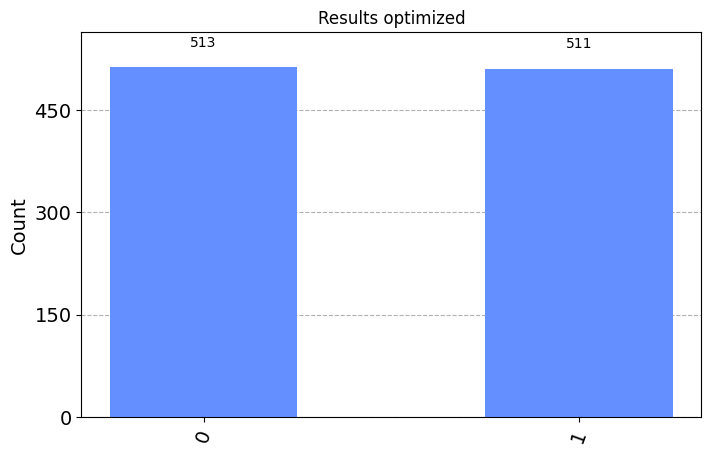

In [67]:
display(plot_histogram(counts,title='Results optimized' ,figsize=[8,5]))